In [2]:
from packages.loaders import DataLoader
from notebooks.open_datasets.russian_inappropriate_messages.common import path_to_data, path_to_models
import numpy as np
import joblib

all_patterns_preprocessed_and_its_intents_train = DataLoader.load_pandas_dataframe(path_to_data / 'all_patterns_preprocessed_and_its_intents_train.csv', sep=";")
all_patterns_preprocessed_and_its_intents_test = DataLoader.load_pandas_dataframe(path_to_data / 'all_patterns_preprocessed_and_its_intents_test.csv', sep=";")
unique_sorted_words = DataLoader.load_numpy_array(path_to_data / "unique_sorted_words.npy")
unique_sorted_intents = DataLoader.load_numpy_array(path_to_data / "unique_sorted_intents.npy")
all_patterns_preprocessed_and_its_intents_train

pattern            intent
0      ['жить', 'всё', 'понятие', 'закон', 'просто', ...     offline_crime
1      ['удовольствие', 'пообщаться', 'хардингуш', 'т...     offline_crime
2      ['вообще', 'запретить', 'судить', 'сводка', 'д...     offline_crime
3                  ['полковник', 'миллиард', 'воровать']     offline_crime
4      ['чебоксары', 'гайец', 'увидеть', 'регион', 'п...     offline_crime
...                                                  ...               ...
99670   ['зарплата', 'швейцария', 'чтожий', 'маленький']  social_injustice
99671  ['number-number', 'час', 'день', 'начать', 'се...  social_injustice
99672  ['налог', 'слишком', 'мало', 'нужно', 'большой...  social_injustice
99673  ['чтолько', 'постройка', 'соответствовать', 'с...  social_injustice
99674  ['везде', 'просчто', 'жесть', 'но-в', 'number'...  social_injustice

[99675 rows x 2 columns]

In [3]:
all_patterns_preprocessed_and_its_intents_test['pattern'] = all_patterns_preprocessed_and_its_intents_test['pattern'].apply(
    lambda x: eval(x))

all_patterns_preprocessed_and_its_intents_train['pattern'] = all_patterns_preprocessed_and_its_intents_train['pattern'].apply(
    lambda x: eval(x))
all_patterns_preprocessed_and_its_intents_train

pattern            intent
0      [жить, всё, понятие, закон, просто, преступлен...     offline_crime
1      [удовольствие, пообщаться, хардингуш, тип, чёт...     offline_crime
2      [вообще, запретить, судить, сводка, дтп, это, ...     offline_crime
3                        [полковник, миллиард, воровать]     offline_crime
4      [чебоксары, гайец, увидеть, регион, палка, сра...     offline_crime
...                                                  ...               ...
99670           [зарплата, швейцария, чтожий, маленький]  social_injustice
99671  [number-number, час, день, начать, серьёзно, и...  social_injustice
99672  [налог, слишком, мало, нужно, большой, чтогда,...  social_injustice
99673  [чтолько, постройка, соответствовать, строител...  social_injustice
99674  [везде, просчто, жесть, но-в, number, очередь,...  social_injustice

[99675 rows x 2 columns]

In [6]:
from src.packages.pipe.perceptron.preprocess_data import ToSentenceEmbeddingVectorPatternsSBert

encoder_for_patterns = ToSentenceEmbeddingVectorPatternsSBert()

# Могут быть пробемы в дальнейшем при загрузке, лучше импортировать класс ToSentenceEmbeddingVectorPatternsSBert, веса загрузятся тогда автоматически
# joblib.dump(encoder_for_patterns, path_to_models / 'pipelines' / 'sbert_and_perceptron' / 'sbert_encoder_for_patterns.joblib')

encoder_for_patterns.transform(["Привет", "как", "дела"])

tensor([ 0.4576, -0.1188, -0.5923,  ...,  0.1431, -0.7215,  0.2393])

In [7]:
encoder_for_patterns.transform([]).shape, encoder_for_patterns.transform([]).sum()

(torch.Size([1024]), tensor(-0.7146))

100%|██████████| 10/10 [00:57<00:00,  5.72s/it]


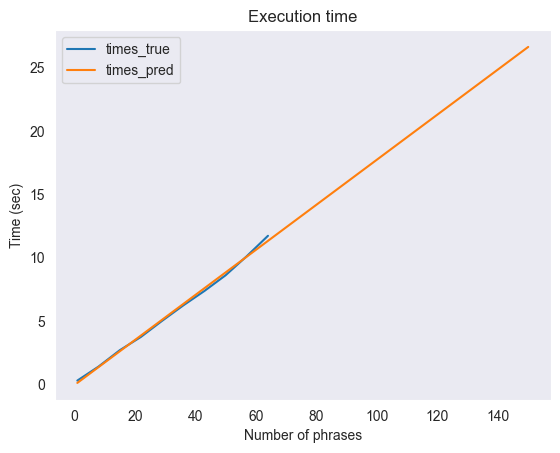

In [8]:
from sklearn.linear_model import LinearRegression
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


def learn_time_func(x_true, x_to_pred, func, all_patterns_and_its_intents, is_plot=True):
    times = []
    for x in tqdm(x_true):
        start_time = time.perf_counter()
        all_patterns_and_its_intents[:x].apply(lambda x: func(x))
        end_time = time.perf_counter()
        times.append(end_time - start_time)

    X = np.array(x_true).reshape((-1, 1))
    time_func = LinearRegression()
    time_func.fit(X, times)
    X_to_pred = np.array(x_to_pred).reshape((-1, 1))
    times_pred = time_func.predict(X_to_pred)

    if is_plot:
        plt.xlabel('Number of phrases')
        plt.ylabel('Time (sec)')
        plt.title('Execution time')
        plt.plot(X, times, label='times_true')
        plt.plot(X_to_pred, times_pred, label='times_pred')
        plt.legend()
        plt.grid()
        plt.show()
    return time_func


x_true = range(1, 71, 7)
x_pred = range(1, 151)
time_func = learn_time_func(x_true, x_pred, encoder_for_patterns.transform, all_patterns_preprocessed_and_its_intents_test["pattern"])

In [9]:
time_func.predict(np.array(all_patterns_preprocessed_and_its_intents_train.shape[0]).reshape((-1, 1))) / 60 / 60

array([4.93130638])

In [10]:
time_func.predict(np.array(all_patterns_preprocessed_and_its_intents_test.shape[0]).reshape((-1, 1))) / 60 / 60

array([1.23658408])

## Предобработаем

In [11]:
data_test = all_patterns_preprocessed_and_its_intents_test
data_train = all_patterns_preprocessed_and_its_intents_train
data_train

pattern            intent
0      [жить, всё, понятие, закон, просто, преступлен...     offline_crime
1      [удовольствие, пообщаться, хардингуш, тип, чёт...     offline_crime
2      [вообще, запретить, судить, сводка, дтп, это, ...     offline_crime
3                        [полковник, миллиард, воровать]     offline_crime
4      [чебоксары, гайец, увидеть, регион, палка, сра...     offline_crime
...                                                  ...               ...
99670           [зарплата, швейцария, чтожий, маленький]  social_injustice
99671  [number-number, час, день, начать, серьёзно, и...  social_injustice
99672  [налог, слишком, мало, нужно, большой, чтогда,...  social_injustice
99673  [чтолько, постройка, соответствовать, строител...  social_injustice
99674  [везде, просчто, жесть, но-в, number, очередь,...  social_injustice

[99675 rows x 2 columns]

In [12]:
from packages.loaders import ModelLoader

one_hot_encoder_for_intents = ModelLoader.load(path_to_models / "pipelines" / "perceptron" / "one_hot_encoder_for_intents.joblib")

data_test["one_hot_vector_of_intent"] = data_test["intent"].apply(lambda x: one_hot_encoder_for_intents.transform(x))
data_train["one_hot_vector_of_intent"] = data_train["intent"].apply(lambda x: one_hot_encoder_for_intents.transform(x))
data_train

pattern            intent  \
0      [жить, всё, понятие, закон, просто, преступлен...     offline_crime   
1      [удовольствие, пообщаться, хардингуш, тип, чёт...     offline_crime   
2      [вообще, запретить, судить, сводка, дтп, это, ...     offline_crime   
3                        [полковник, миллиард, воровать]     offline_crime   
4      [чебоксары, гайец, увидеть, регион, палка, сра...     offline_crime   
...                                                  ...               ...   
99670           [зарплата, швейцария, чтожий, маленький]  social_injustice   
99671  [number-number, час, день, начать, серьёзно, и...  social_injustice   
99672  [налог, слишком, мало, нужно, большой, чтогда,...  social_injustice   
99673  [чтолько, постройка, соответствовать, строител...  social_injustice   
99674  [везде, просчто, жесть, но-в, number, очередь,...  social_injustice   

                                one_hot_vector_of_intent  
0      [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  
1      [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  
2      [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  
3      [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  
4      [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  
...                                                  ...  
99670  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
99671  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
99672  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
99673  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
99674  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[99675 rows x 3 columns]

In [13]:
from tqdm import tqdm
tqdm.pandas()

data_test["vector_of_pattern"] = data_test["pattern"].progress_apply(lambda x: encoder_for_patterns.transform(x))
data_test

 35%|███▍      | 8709/24995 [26:09<45:03,  6.02it/s]  

In [14]:
data_test = data_test.sample(frac=1)
data_test

In [21]:
test_x = data_test['vector_of_pattern']
test_y = data_test['one_hot_vector_of_intent']
test_x = np.array(test_x)
test_y = np.array(test_y.tolist())
test_x

array([tensor([-0.0734, -0.3822,  0.3994,  ...,  0.1282, -0.1762, -0.2650]),
       tensor([ 0.4407, -0.0101,  0.0471,  ..., -0.0774,  0.2125,  0.5170]),
       tensor([ 0.1819, -0.2135, -0.1021,  ...,  0.1325,  0.5620,  0.9964]),
       ...,
       tensor([-0.0760, -0.5791,  0.6972,  ..., -0.4190,  0.5583,  0.0827]),
       tensor([ 0.4725, -0.0726, -0.1371,  ..., -0.1716,  0.3061, -0.1381]),
       tensor([ 0.3036, -0.4466,  0.5063,  ..., -0.0973,  0.0869,  0.3485])],
      dtype=object)

In [22]:
test_x.shape, test_y.shape

((24995,), (24995, 18))

In [27]:
np.save(str(path_to_data / 'sbert_and_perceptron' / 'data_dense_index_test.npy'), np.array(data_test.index))
np.save(str(path_to_data / 'sbert_and_perceptron' / 'test_x_dense_for_perceptron.npy'), test_x)
np.save(str(path_to_data / 'sbert_and_perceptron' / 'test_y_dense_for_perceptron.npy'), test_y)

In [24]:
# В какой-то момент времени прогресс бар ломается и перестаёт выводиться любой результат
# работы ячейки в pycharm, даже через print. Через jupiter web выводится.
data_train["vector_of_pattern"] = data_train["pattern"].progress_apply(lambda x: encoder_for_patterns.transform(x))
data_train

 15%|█▌        | 15047/99675 [1:09:59<7:14:57,  3.24it/s]

In [31]:
data_train = data_train.sample(frac=1)
data_train

In [32]:
train_x = data_train['vector_of_pattern']
train_y = data_train['one_hot_vector_of_intent']
train_x = np.array(train_x)
train_y = np.array(train_y.tolist())
train_x

In [33]:
train_x.shape, train_y.shape

In [34]:
np.save(str(path_to_data / 'sbert_and_perceptron' / 'data_dense_index_train.npy'), np.array(data_train.index))
np.save(str(path_to_data / 'sbert_and_perceptron' / 'train_x_dense_for_perceptron.npy'), train_x)
np.save(str(path_to_data / 'sbert_and_perceptron' / 'train_y_dense_for_perceptron.npy'), train_y)